<a href="https://colab.research.google.com/github/DHANUNJAY718/recipe-finder/blob/main/Detection%20of%20Phishing%20Websites%20Using%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix

import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics
import matplotlib.pyplot as plt # It provides an object-oriented API for embedding plots into applications
%matplotlib inline
# It sets the backend of matplotlib to the 'inline' backend:
import time # calculate time

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos


import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model

import warnings # ignores pink warnings
warnings.filterwarnings('ignore')

In [2]:
phish_data = pd.read_csv(r"/content/phishing_site_urls.csv")

In [3]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


* **About dataset**
* Data is containg 5,49,346 unique entries.
* There are two columns.
* Label column is prediction col which has 2 categories
    A. Good - which means the urls is not containing malicious stuff and **this site is not a Phishing Site.**
    B. Bad - which means the urls contains malicious stuffs and **this site isa Phishing Site.**
* There is no missing value in the dataset.

In [4]:
phish_data.isnull().sum() # there is no missing values

,0
URL,0
Label,0


In [6]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

### Preprocessing

* **Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.**

#### RegexpTokenizer
* A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [8]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [9]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [10]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [11]:
# Tokenizing all the rows
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 4.100808537999967 sec


In [12]:
phish_data.sample(5)

,URL,Label,text_tokenized
442108,teachersity.org/resource_detail.php?cat_id=7&c...,good,"[teachersity, org, resource, detail, php, cat,..."
323068,ericdigests.org/pre-927/soviet.htm,good,"[ericdigests, org, pre, soviet, htm]"
361125,imtl.org/montreal/building/Eglise_Notre-Dame-d...,good,"[imtl, org, montreal, building, Eglise, Notre,..."
454368,tynebuiltships.co.uk/ShipsC.html,good,"[tynebuiltships, co, uk, ShipsC, html]"
174183,en.wikipedia.org/wiki/E._R._Ward_Neale_Medal,good,"[en, wikipedia, org, wiki, E, R, Ward, Neale, ..."


#### SnowballStemmer
* Snowball is a small string processing language, gives root words

In [13]:
stemmer = SnowballStemmer("english") # choose a language

In [14]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 53.39207284700001 sec


In [15]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
290078,behindthename.com/top/,good,"[behindthename, com, top]","[behindthenam, com, top]"
17951,delawareairsoft.com/edf/particuliers/particuli...,bad,"[delawareairsoft, com, edf, particuliers, part...","[delawareairsoft, com, edf, particuli, particu..."
85871,www.linuxfocus.org/English/November1999/articl...,good,"[www, linuxfocus, org, English, November, arti...","[www, linuxfocus, org, english, novemb, articl..."
74272,home.iae.nl/users/mhx/i4faq.html,good,"[home, iae, nl, users, mhx, i, faq, html]","[home, iae, nl, user, mhx, i, faq, html]"
27207,paypal.com.us-cgi-bin-webscr-cmd.login.5885d80...,bad,"[paypal, com, us, cgi, bin, webscr, cmd, login...","[paypal, com, us, cgi, bin, webscr, cmd, login..."


In [16]:
# Joining all the stemmmed words.
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.26051965700003166 sec


In [17]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
356220,ian-ko.com/ET_GeoBox/gb_main.htm,good,"[ian, ko, com, ET, GeoBox, gb, main, htm]","[ian, ko, com, et, geobox, gb, main, htm]",ian ko com et geobox gb main htm
515267,91.239.24.112:6892,bad,[],[],
58864,www.cs.toronto.edu/~xerion/,good,"[www, cs, toronto, edu, xerion]","[www, cs, toronto, edu, xerion]",www cs toronto edu xerion
210475,mafiaslugger.blogspot.com/,good,"[mafiaslugger, blogspot, com]","[mafiaslugg, blogspot, com]",mafiaslugg blogspot com
82715,www.webring.com/hub?ring=dreamworldsterra,good,"[www, webring, com, hub, ring, dreamworldsterra]","[www, webr, com, hub, ring, dreamworldsterra]",www webr com hub ring dreamworldsterra


### Visualization
**1. Visualize some important keys using word cloud**

In [18]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [19]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [20]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


### Creating Model

#### CountVectorizer
* CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [21]:
#create cv object
cv = CountVectorizer()

In [22]:
#help(CountVectorizer())

In [23]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [24]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### * Spliting the data

In [25]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

### LogisticRegression
* Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [26]:
# create lr object
lr = LogisticRegression()

In [27]:
lr.fit(trainX,trainY)

LogisticRegression()

In [28]:
lr.score(testX,testY)

0.9649693818854351

.*** Logistic Regression is giving 96% accuracy, Now we will store scores in dict to see which model perform best**

In [29]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9784737712040271
Testing Accuracy : 0.9649693818854351

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36500
        Good       0.99      0.96      0.98    100837

    accuracy                           0.96    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.96      0.97    137337


CONFUSION MATRIX


<Axes: >

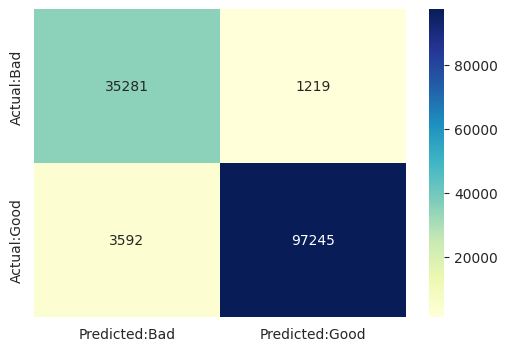

In [30]:
# creating confusing matrix
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### MultinomialNB
* Applying Multinomial Naive Bayes to NLP Problems. Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [31]:
# create mnb object
mnb = MultinomialNB()

In [32]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [33]:
mnb.score(testX,testY)

0.9586855690746121

*** MultinomialNB gives us 95% accuracy**  

In [34]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9740806632864816
Testing Accuracy : 0.9586855690746121

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.94      0.93     37881
        Good       0.98      0.97      0.97     99456

    accuracy                           0.96    137337
   macro avg       0.95      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


<Axes: >

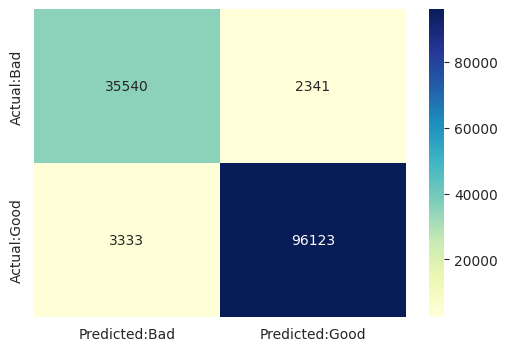

In [35]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

*** So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression**

In [38]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+) -- these tolenizers giving me low accuray

In [39]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [40]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [41]:
pipeline_ls.score(testX,testY)

0.966542155427889

Training Accuracy : 0.9797552966075984
Testing Accuracy : 0.966542155427889

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     37113
        Good       0.99      0.97      0.98    100224

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<Axes: >

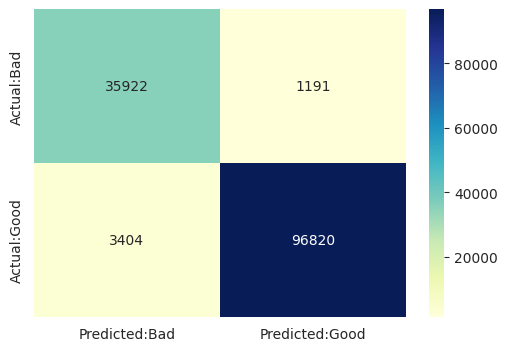

In [42]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

**Lets dump the model in pickle.**

In [43]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [44]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.966542155427889


***That’s it. See, it's that simple yet so effective. We get an accuracy of 98%. That’s a very high value for a machine to be able to detect a malicious URL with. Want to test some links to see if the model gives good predictions? Sure. Let's do it**

In [49]:
predict_bad = ['www.gvpce.ac.in']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)


['good']


https://research.aalto.fi/en/datasets/phishstorm-phishing-legitimate-url-dataset